In [1]:
import torch
import torch.nn as nn
# import torchvision
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import lmdb
from torch.utils.data import DataLoader
from data.dataloader import get_loaders, get_eval_loader
from data.dataset import ICDR2015Dataset, TransformDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from shapely.geometry import Polygon
from data.process.utils import *
from torchvision.ops import FeaturePyramidNetwork
import torch.nn.functional as F
from fast import FAST
from shapely.geometry import Polygon, MultiPolygon
from shapely.validation import explain_validity, make_valid
from models.utils import *
import pyclipper
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2

In [7]:
train_loader, val_loader = get_loaders('data', batch_size=2, train=False)

In [10]:
model = FAST().cuda()
checkpoint = torch.load('models/checkpoints/fast_416', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
checkpoint['epoch'], checkpoint['train_loss'], checkpoint['val_loss']

(999, 0.37511258232593536, 0.34740552395582197)

0.57899010181427
0.47498592734336853


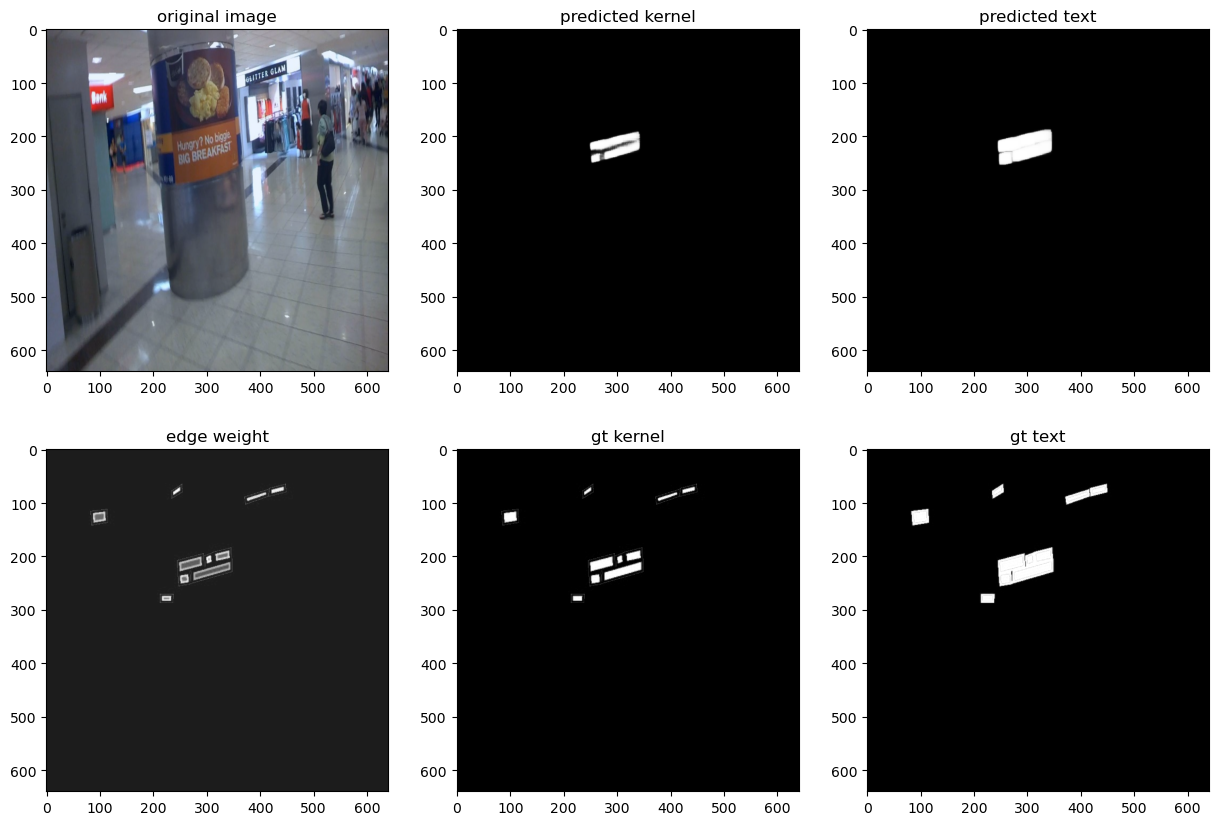

In [11]:
images, labels = next(iter(val_loader))
i = 0

image = images[i].cuda().unsqueeze(0)
gt_kernel = labels["maps"][i, 0].cuda().unsqueeze(0)
gt_text = labels["maps"][i, 1].cuda().unsqueeze(0)
edge_weight = labels["maps"][i, 2].cuda().unsqueeze(0)

model.eval()
out = model(image, gt_kernel, gt_text, edge_weight)
loss = out["loss"]
print(loss[0].item())
out = out["output"]
print(((out * gt_kernel).sum() / (out + gt_kernel - out * gt_kernel).sum()).item())
out2 = F.max_pool2d(out, 9, stride=1, padding=4)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0][0].imshow(
    ((image - image.min()) / (image.max() - image.min()))
    .cpu()
    .squeeze()
    .permute(1, 2, 0)
)
axs[0][0].set_title("original image")

axs[0][1].imshow(out.detach().cpu().squeeze(), vmin=0, vmax=1, cmap="gray")
axs[0][1].set_title("predicted kernel")
axs[0][2].imshow(out2.detach().cpu().squeeze(), vmin=0, vmax=1, cmap="gray")
axs[0][2].set_title("predicted text")

axs[1][0].imshow(edge_weight.detach().cpu().squeeze(), vmin=0, cmap="gray")
axs[1][0].set_title("edge weight")
axs[1][1].imshow(gt_kernel.detach().cpu().squeeze(), vmin=0, vmax=1, cmap="gray")
axs[1][1].set_title("gt kernel")
axs[1][2].imshow(gt_text.detach().cpu().squeeze(), vmin=0, vmax=1, cmap="gray")
axs[1][2].set_title("gt text")
plt.show()

In [75]:
bboxes = labels['bboxes'][i]

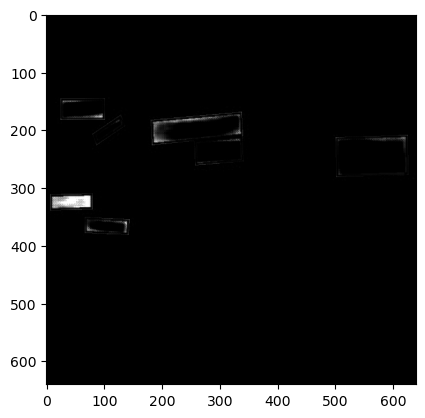

In [77]:
map = F.binary_cross_entropy(out.squeeze(), gt_kernel.squeeze(), reduction='none').cpu().detach().numpy()
plt.imshow(map, cmap='gray')
# for bbox in bboxes:
#     plt.plot(*Polygon(bbox).exterior.xy)

In [76]:
x = [] # area
y = [] # loss

In [77]:
# images, labels = next(iter(val_loader)) 
model.eval()
out = model(images.cuda(), labels['maps'][:, 0].cuda(), labels['maps'][:, 1].cuda(), labels['maps'][:, 2].cuda())

for j in range(16):
    bboxes = labels['bboxes'][j]
    map = F.binary_cross_entropy(out['output'].squeeze(1), labels['maps'][:, 0].cuda(), reduction='none').cpu().detach().numpy()

    for bbox in bboxes:
        poly = Polygon(bbox)
        poly2 = poly.buffer(5)

        mask = np.zeros_like(map[j])
        cv.fillPoly(mask, [np.array(poly2.exterior.coords, dtype=np.int32)], 1)
        loss_map = map[j] * mask
        x.append([poly.area, poly.length])
        y.append(loss_map.sum())

In [78]:
x = np.array(x)
y = np.array(y)

In [67]:
x.mean(0), x.std(0), y.mean(), y.std()

(array([4431.69557077,  252.78616009]),
 array([6718.58025596,  143.19079937]),
 2591.6375,
 3113.4336)

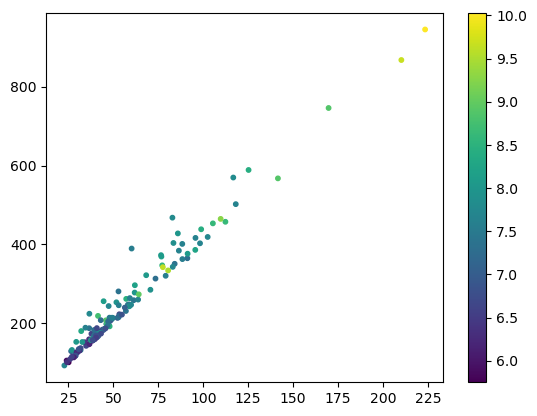

In [68]:
plt.scatter(np.sqrt(x[:, 0]), x[:, 1], c=np.log(y), s=10, cmap='viridis')
plt.colorbar()
plt.show()

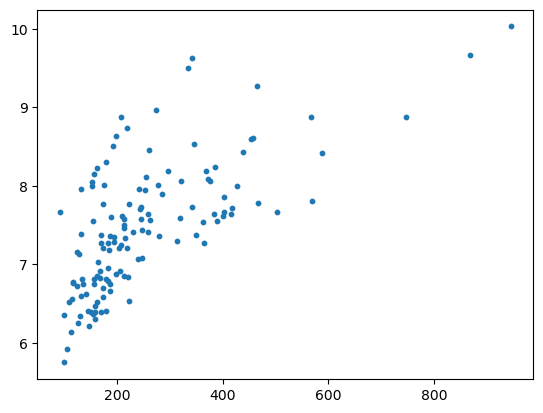

In [69]:
plt.scatter(x[:, 1], np.log(y), s=10)

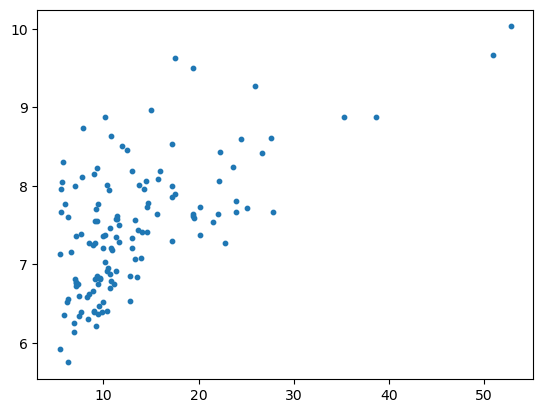

In [70]:
plt.scatter(x[:, 0] / x[:, 1], np.log(y), s=10)

In [79]:
A = np.hstack([(x[:, 0]).reshape(-1, 1), np.ones((x.shape[0], 1))])
b = y.reshape(-1, 1)

np.linalg.inv(A.T @ A) @ A.T @ b

array([[4.18532338e-01],
       [2.11562353e+03]])

In [73]:
A = np.hstack([(x[:, 0]).reshape(-1, 1), np.ones((x.shape[0], 1))])
b = y.reshape(-1, 1)

np.linalg.inv(A.T @ A) @ A.T @ b

array([[3.45644853e-01],
       [1.05984475e+03]])

In [74]:
3e-1

0.3

2434.1284


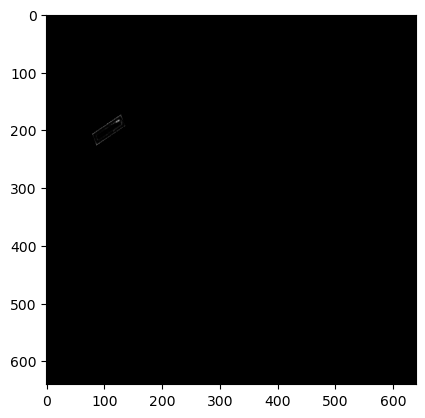

In [87]:
a = np.zeros_like(map)
cv.fillPoly(a, [bboxes[0].astype(np.int32)], 1)
b = map * a

plt.imshow(b, cmap='gray')
print(b.sum())

In [65]:
# 366
checkpoint = torch.load('models/checkpoints/fast_366', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, val_loader)

100%|██████████| 5368/5368 [1:09:57<00:00,  1.28it/s]

Precision: 0.8399 | Recall: 0.7730 | F1: 0.7923


In [62]:
# 403
checkpoint = torch.load('models/checkpoints/fast_403', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, val_loader)

100%|██████████| 5368/5368 [1:11:57<00:00,  1.24it/s]


Precision: 0.8765 | Recall: 0.8207 | F1: 0.8374


In [64]:
# 416 - 600
checkpoint = torch.load('models/checkpoints/cp_600', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, val_loader)

100%|██████████| 5368/5368 [1:08:54<00:00,  1.30it/s]

Precision: 0.8840 | Recall: 0.7870 | F1: 0.8225


In [63]:
# 416
checkpoint = torch.load('models/checkpoints/fast_416', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, val_loader)

100%|██████████| 5368/5368 [1:13:34<00:00,  1.22it/s]

Precision: 0.9067 | Recall: 0.8024 | F1: 0.8424


In [16]:
# 366
checkpoint = torch.load('models/checkpoints/fast_366', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, train_loader)

100%|██████████| 600/600 [00:49<00:00, 12.05it/s]

Precision: 0.2939 | Recall: 0.1082 | F1: 0.1363


In [17]:
# 403
checkpoint = torch.load('models/checkpoints/fast_403', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, train_loader)

100%|██████████| 600/600 [00:50<00:00, 11.99it/s]

Precision: 0.3571 | Recall: 0.1388 | F1: 0.1752


In [18]:
# 416 - 600
checkpoint = torch.load('models/checkpoints/cp_600', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, train_loader)

100%|██████████| 600/600 [00:52<00:00, 11.50it/s]

Precision: 0.4012 | Recall: 0.1644 | F1: 0.2057


In [19]:
# 416
checkpoint = torch.load('models/checkpoints/fast_416', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate(model, train_loader)

100%|██████████| 600/600 [00:49<00:00, 12.04it/s]

Precision: 0.4011 | Recall: 0.1489 | F1: 0.1909


In [432]:
evaluate(model, train_loader)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:20<00:00,  3.71it/s]

Precision: 0.7235 | Recall: 0.6451 | F1: 0.6576


In [3]:
it = iter(train_loader)
images = []
masks = []

for i in range(25):
    image, maps = next(it)
    images.append(image[0])
    masks.append(maps['gt_text'][0].squeeze())

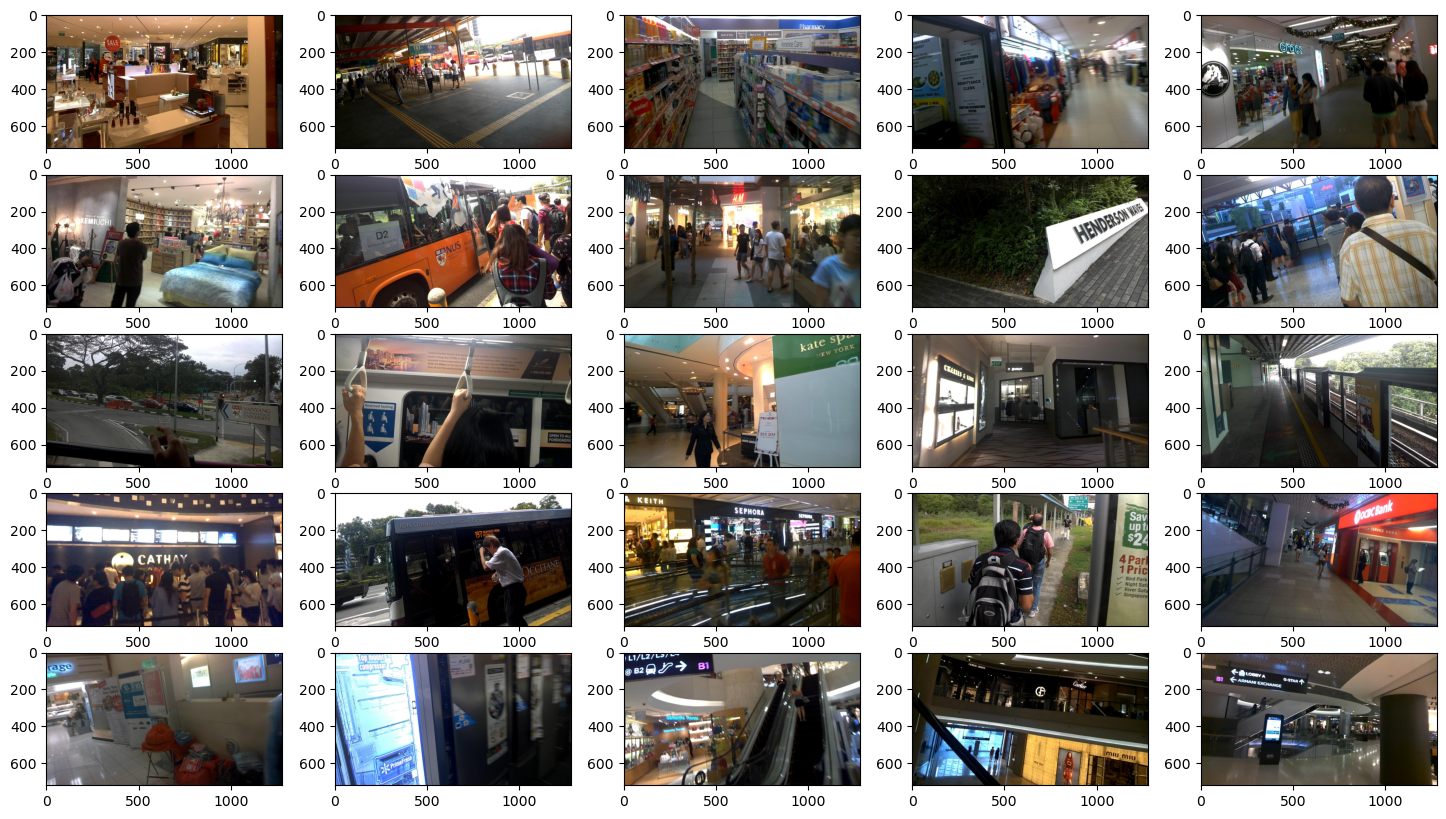

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(18, 10))

i = 0
for row in axs:
    for col in row:
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        col.imshow(img)
        i += 1

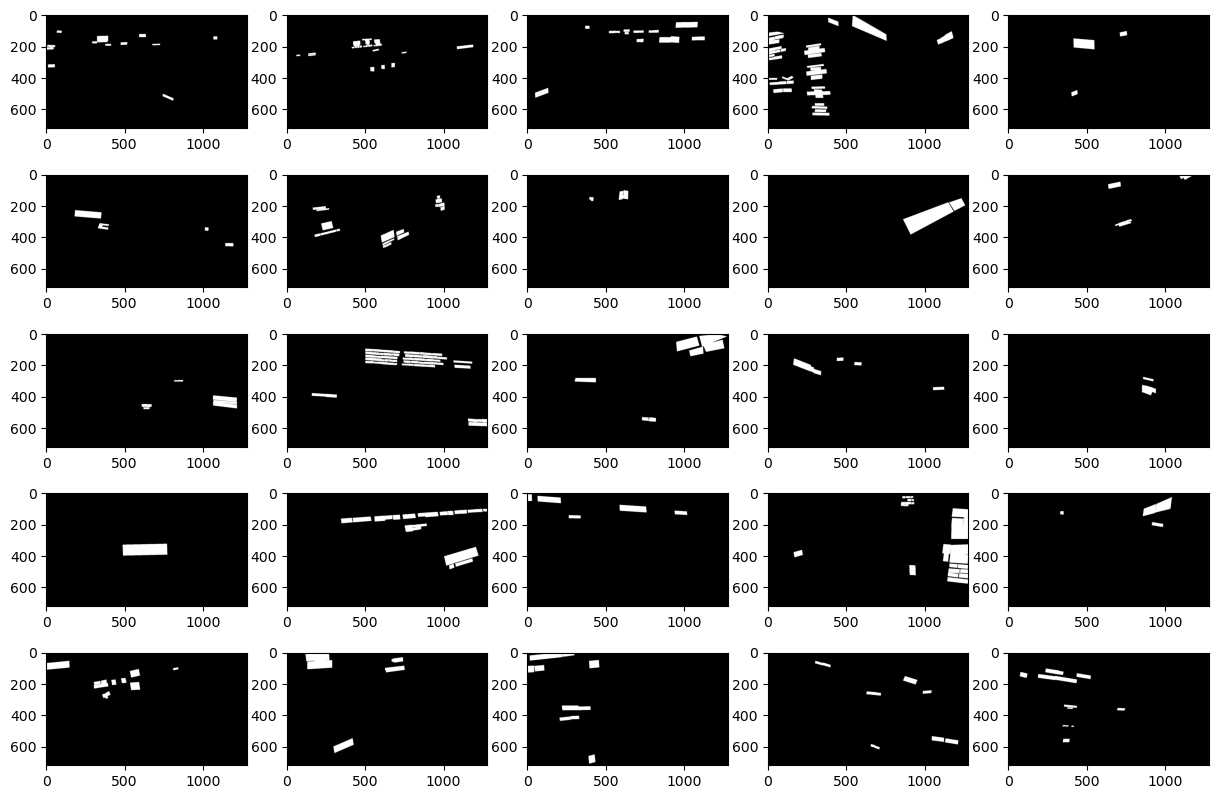

In [5]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))

i = 0
for row in axs:
    for col in row:
        col.imshow(masks[i], cmap='gray')
        i += 1

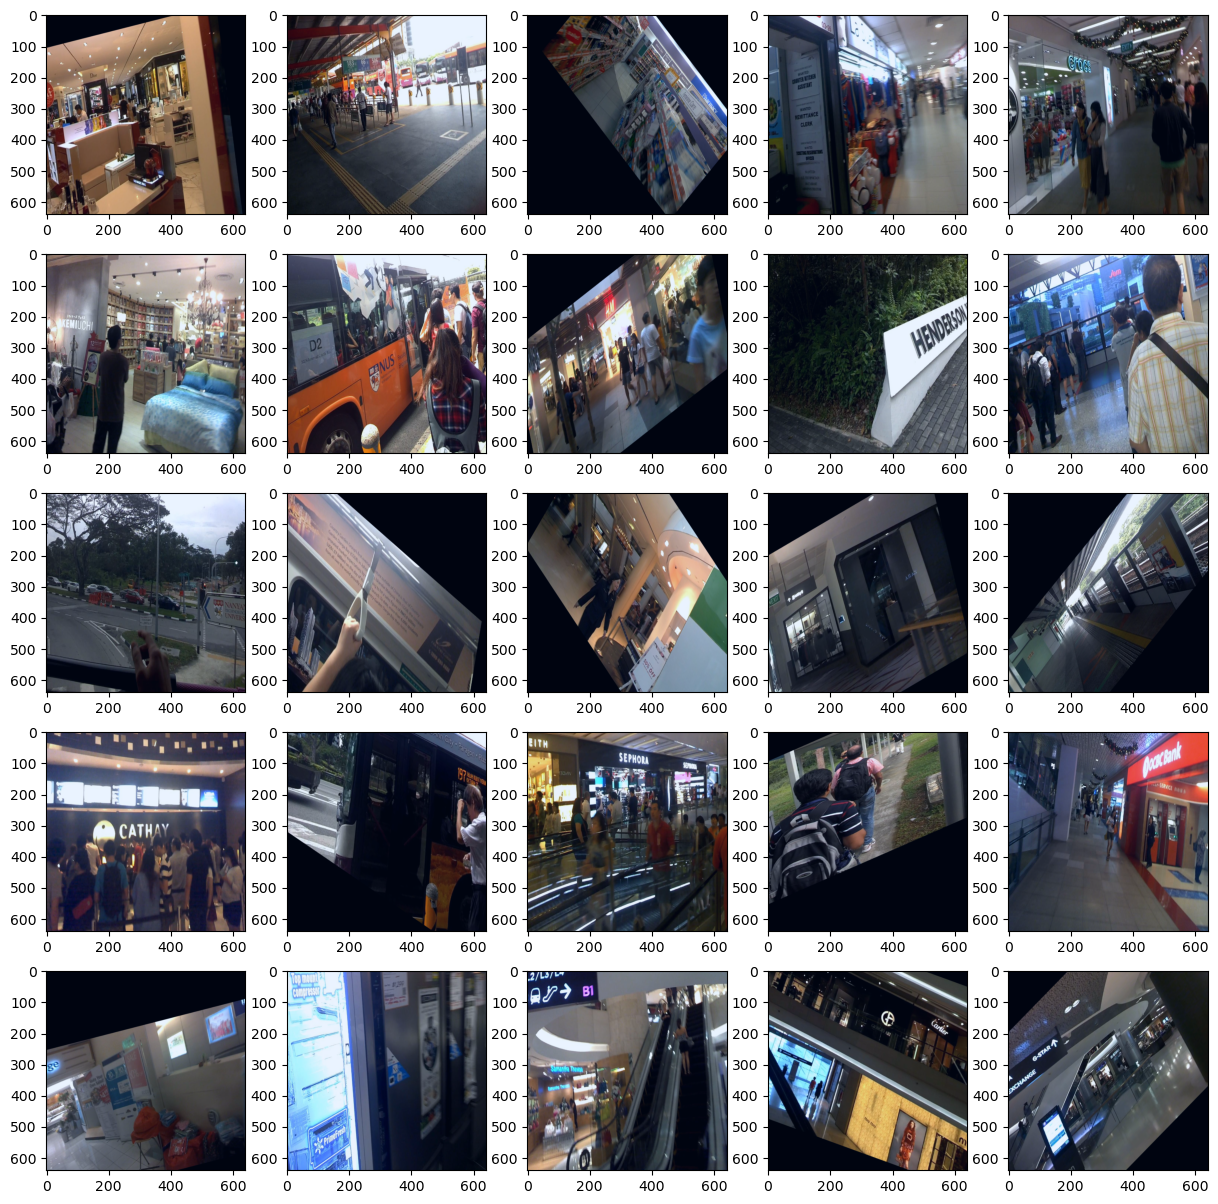

In [54]:
transform = A.Compose([
    A.Affine(
        scale=(2 / 3, 3 / 2),
        translate_percent=(-0.2, 0.2),
        rotate=(-45, 45),
        shear=(-10, 10),
        balanced_scale=True
    ),
    A.RandomResizedCrop(
        size=(640, 640),
        scale=(0.9, 1.0),
        ratio=(2 / 3, 3 / 2)
    ),
    A.Normalize(),
    # A.GaussNoise(p=1.0),
    # A.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=0),
    # A.AdvancedBlur(),
    # A.Sharpen(),
])


fig, axs = plt.subplots(5, 5, figsize=(15, 15))

trans_masks = []
i = 0
for row in axs:
    for col in row:
        trans = transform(image=images[i].permute(1, 2, 0).numpy(), mask=masks[i].numpy())
        img = trans['image']
        trans_masks.append(trans['mask'])
        
        img = (img - img.min()) / (img.max() - img.min())
        col.imshow(img)
        i += 1

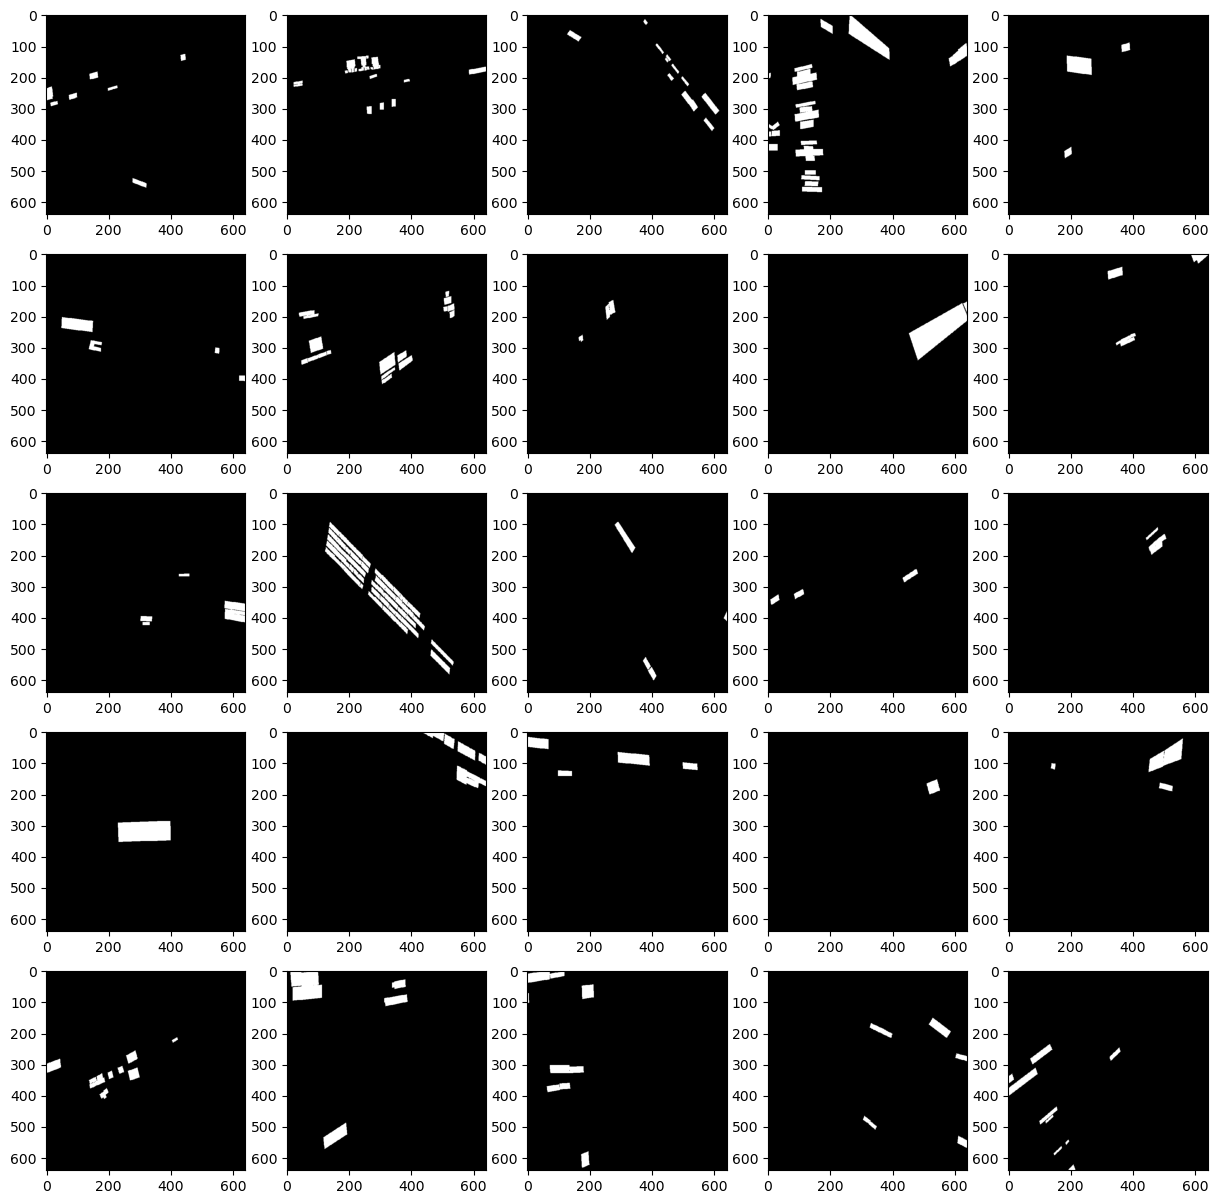

In [55]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

i = 0
for row in axs:
    for col in row:
        col.imshow(trans_masks[i], cmap='gray')
        i += 1